# VQLS for a small system (Case I)

Defining Case I: Solving Ax=b 

A = diag (1,1,1,1/kappa)

b = 1/2 (1,1,1,1)


In [95]:
#Importing necessary packages and functions
from qiskit import QuantumCircuit,transpile
import numpy as np
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, Statevector
from qiskit.circuit.library import TwoLocal,n_local
from scipy.optimize import minimize
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator


In [29]:
#Setting up Case I and classical Solution
def CaseI_A_matrix(kappa):
    return np.diag([1.0, 1.0, 1.0, 1.0/float(kappa)])

def make_U(choice):
    qc = QuantumCircuit(2)
    if choice == "H0":
        qc.h(0)
    elif choice == "H1":
        qc.h(1)
    elif choice == "CNOT":
        qc.cx(0,1)
    elif choice == "H0_CNOT":
        qc.h(0); qc.cx(0,1)
    elif choice == "H0H1_CNOT":
        qc.h(0); qc.h(1); qc.cx(0,1)
    return Operator(qc).data

def rotate_A(A, U):
    return U.conj().T @ A @ U

def b_bell_4():
    b = np.array([1,0,0,1], dtype=float)
    return b/np.linalg.norm(b)

def make_b_uniform():
    b = np.ones(4) / 2.0
    return b

def normalize(v):
    return v / np.linalg.norm(v)

def classical_solution(A, b):
    x = np.linalg.solve(A, b)
    return normalize(x)

In [30]:
#Creating Cost Hamiltonian
def op_from_matrix(M):
    return SparsePauliOp.from_operator(M)

def identity_op(n_qubits):
    return SparsePauliOp.from_list([("I"*n_qubits, 1.0)])

def cost_hamiltonian(A_op, b_state):
    n_qubits = int(np.log2(len(b_state)))
    I = identity_op(n_qubits)
    B_dm = DensityMatrix(b_state)           # |b><b|
    B_op = SparsePauliOp.from_operator(B_dm)
    H = A_op @ (I - B_op) @ A_op
    # hermitianize & real-coeff cleanup
    H = 0.5*(H + H.adjoint())
    H = SparsePauliOp(H.paulis, coeffs=np.real(H.coeffs))
    return H

In [31]:
#Creating ansatz (n-local circuit)
def make_ansatz(n_qubits,reps):
    return n_local(n_qubits, rotation_blocks="ry", entanglement_blocks="cx", entanglement="linear", reps=reps,insert_barriers = False)

In [32]:
#Creating certain benchmarks
#Pauli Count
def pauli_term_count(op: SparsePauliOp):
    return len(op.paulis)

def state_from_params(ansatz, params):
    qc = QuantumCircuit(ansatz.num_qubits)
    qc.compose(ansatz.assign_parameters(params), inplace=True)
    return Statevector.from_instruction(qc).data

def fidelity(x_true, x_pred):
    # both normalized real vectors → use abs inner product squared
    return np.abs(np.vdot(x_true, x_pred))**2

In [87]:
#Final function


def run_vqls_CaseI(kappa, reps, optimizer="COBYLA", maxiter=300, seed=0):
    np.random.seed(seed)

    # Build A and b
    A = CaseI_A_matrix(kappa)
    #A = familyA_A(kappa)
    U = make_U("H0_CNOT")
    A_mat = rotate_A(A, U)
    b = b_bell_4()
    #b = make_b_uniform()
    b = normalize(b)
    x_true = classical_solution(A_mat, b)

    # Operators
    A_op = SparsePauliOp.from_operator(A_mat)
    H = cost_hamiltonian(A_op, b)

    # Ansatz
    ansatz = make_ansatz(n_qubits=2, reps=reps)

    # Estimator
    estimator = EstimatorV2()

    def costfunc(params):
        job = estimator.run([(ansatz, H, params)])
        return float(job.result()[0].data.evs)

    init = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

    res = minimize(costfunc, init, method=optimizer, options={"maxiter": maxiter, "tol": 1e-10})

    # Evaluate final state
    x_pred = state_from_params(ansatz, res.x)
    x_pred = normalize(x_pred)

    # Optional: align global sign for nicer comparisons
    if np.real(np.vdot(x_true, x_pred)) < 0:
        x_pred = -x_pred
    
    raw_residual = np.linalg.norm(A_mat @ x_pred - b)
    
    Ax = A_mat @ x_pred
    alpha = np.vdot(Ax, b) / np.vdot(Ax, Ax)   
    scaled_residual = np.linalg.norm(alpha*Ax - b)

    return {
        "kappa": kappa,
        "reps": reps,
        "optimizer": optimizer,
        "final_cost": res.fun,
        "iters": res.nfev,          # note: this is function evals, not iterations
        "fidelity": fidelity(x_true, x_pred),
        "A_terms": pauli_term_count(A_op),
        "H_terms": pauli_term_count(H),
        "x_true": x_true,
        "x_pred": x_pred,
        "raw_residual": raw_residual,
        "scaled_residual": scaled_residual
    }

In [89]:
#For different functions
kappas = [1, 3, 10, 30, 100]
reps_list = [1, 2, 3]

results = []
for reps in reps_list:
    for kappa in kappas:
        out = run_vqls_CaseI(kappa, reps=reps, maxiter=300, seed=1)
        results.append(out)
        print(out)

{'kappa': 1, 'reps': 1, 'optimizer': 'COBYLA', 'final_cost': np.float64(-3.3306690738754696e-16), 'iters': np.int64(135), 'fidelity': np.float64(1.0000000000000004), 'A_terms': 1, 'H_terms': 10, 'x_true': array([ 7.07106781e-01+0.j,  1.58187870e-17+0.j, -1.58187870e-17+0.j,
        7.07106781e-01+0.j]), 'x_pred': array([7.07106783e-01+0.j, 2.05738957e-09+0.j, 2.01228558e-09+0.j,
       7.07106779e-01+0.j]), 'raw_residual': np.float64(3.925551477472358e-09), 'scaled_residual': np.float64(3.925551477472356e-09)}
{'kappa': 3, 'reps': 1, 'optimizer': 'COBYLA', 'final_cost': np.float64(7.28583859910259e-17), 'iters': np.int64(162), 'fidelity': np.float64(0.9999999999999991), 'A_terms': 4, 'H_terms': 160, 'x_true': array([ 8.16496581e-01+0.j, -4.08248290e-01+0.j, -9.13298096e-18+0.j,
        4.08248290e-01+0.j]), 'x_pred': array([ 8.16496584e-01-0.j, -4.08248271e-01-0.j,  1.46792328e-08-0.j,
        4.08248303e-01-0.j]), 'raw_residual': np.float64(0.42264971553516095), 'scaled_residual': np.

Comaprison Plots

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# results = [ {...}, {...}, ... ]  # your list of dicts

df = pd.DataFrame(results)

# Convert numpy scalar types to python floats for safety (optional)
for col in ["final_cost", "fidelity","raw_residual","scaled_residual"]:
    if col in df.columns:
        df[col] = df[col].astype(float)
for col in ["iters", "kappa", "reps"]:
    if col in df.columns:
        df[col] = df[col].astype(int)

#print(df.sort_values(["reps","kappa"]).to_string(index=False))

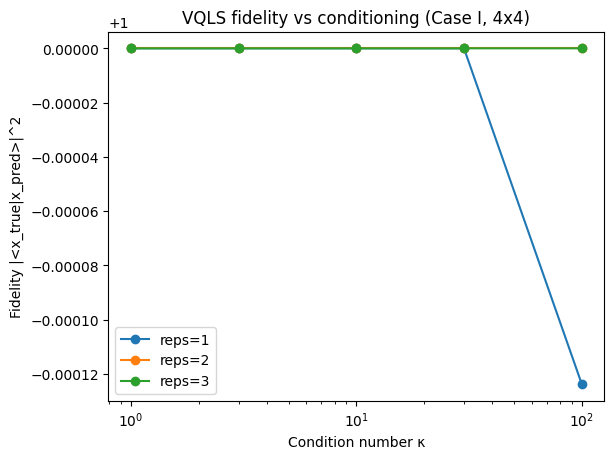

In [77]:
#Fidelity vs kappa (curves by reps)
plt.figure()
for reps, sub in df.groupby("reps"):
    sub = sub.sort_values("kappa")
    plt.plot(sub["kappa"], sub["fidelity"], marker="o", label=f"reps={reps}")
plt.xscale("log")
plt.xlabel("Condition number κ")
plt.ticklabel_format(style='plain', axis='y')
#plt.ylim(0.9999994, 1.2)
plt.ylabel("Fidelity |<x_true|x_pred>|^2")
plt.title("VQLS fidelity vs conditioning (Case I, 4x4)")
plt.legend()
plt.show()

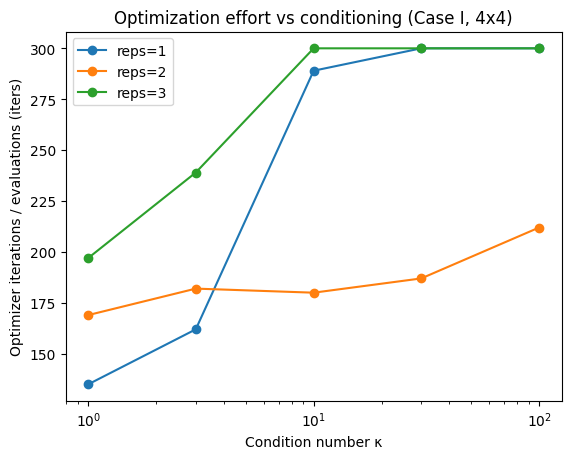

In [78]:
# Iterations vs kappa
plt.figure()
for reps, sub in df.groupby("reps"):
    sub = sub.sort_values("kappa")
    plt.plot(sub["kappa"], sub["iters"], marker="o", label=f"reps={reps}")
plt.xscale("log")
plt.xlabel("Condition number κ")
plt.ylabel("Optimizer iterations / evaluations (iters)")
plt.title("Optimization effort vs conditioning (Case I, 4x4)")
plt.legend()
plt.show()

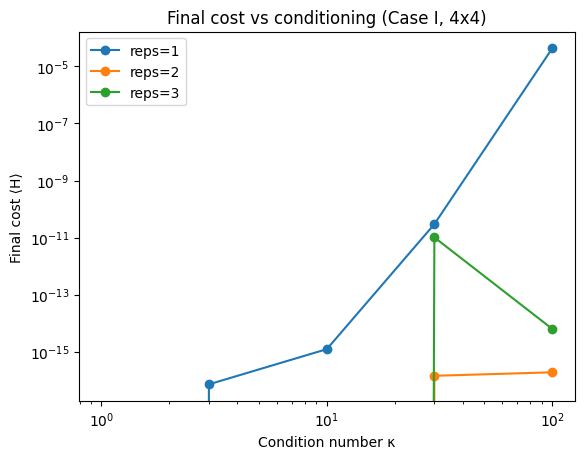

In [65]:
#Final cost vs kappa
plt.figure()
for reps, sub in df.groupby("reps"):
    sub = sub.sort_values("kappa")
    plt.plot(sub["kappa"], sub["final_cost"], marker="o", label=f"reps={reps}")
plt.xscale("log")
plt.yscale("log")  # costs often span orders of magnitude
plt.xlabel("Condition number κ")
plt.ylabel("Final cost ⟨H⟩")
plt.title("Final cost vs conditioning (Case I, 4x4)")
plt.legend()
plt.show()

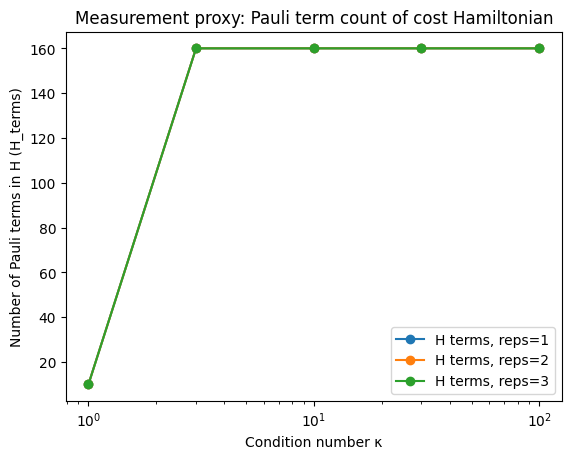

In [79]:
#Pauli term counts (measurement proxy): A_terms and H_terms
if "A_terms" in df.columns and "H_terms" in df.columns:
    plt.figure()
    for reps, sub in df.groupby("reps"):
        sub = sub.sort_values("kappa")
        plt.plot(sub["kappa"], sub["H_terms"], marker="o", label=f"H terms, reps={reps}")
    plt.xscale("log")
    plt.xlabel("Condition number κ")
    plt.ylabel("Number of Pauli terms in H (H_terms)")
    plt.title("Measurement proxy: Pauli term count of cost Hamiltonian")
    plt.legend()
    plt.show()

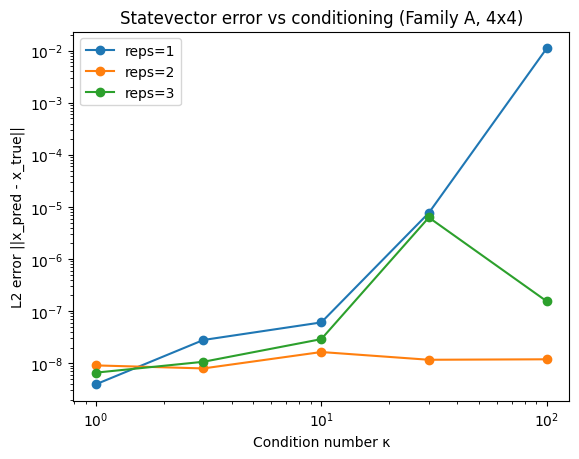

In [80]:



# 5) Optional: error norm ||x_pred - x_true|| (uses stored x vectors)
if "x_true" in df.columns and "x_pred" in df.columns:
    def vec_err(row):
        xt = np.array(row["x_true"], dtype=complex)
        xp = np.array(row["x_pred"], dtype=complex)
        # normalize both (should already be normalized, but safe)
        xt = xt / np.linalg.norm(xt)
        xp = xp / np.linalg.norm(xp)
        return float(np.linalg.norm(xp - xt))

    df["l2_error"] = df.apply(vec_err, axis=1)

    plt.figure()
    for reps, sub in df.groupby("reps"):
        sub = sub.sort_values("kappa")
        plt.plot(sub["kappa"], sub["l2_error"], marker="o", label=f"reps={reps}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Condition number κ")
    plt.ylabel("L2 error ||x_pred - x_true||")
    plt.title("Statevector error vs conditioning (Family A, 4x4)")
    plt.legend()
    plt.show()

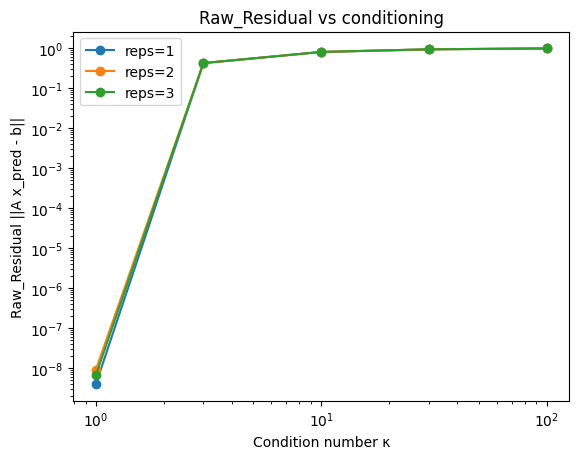

In [81]:

for reps, sub in df.groupby("reps"):
        sub = sub.sort_values("kappa")
        plt.plot(sub["kappa"], sub["raw_residual"], marker="o", label=f"reps={reps}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Condition number κ")
plt.ylabel("Raw_Residual ||A x_pred - b||")
plt.title("Raw_Residual vs conditioning")
plt.legend()
plt.show()

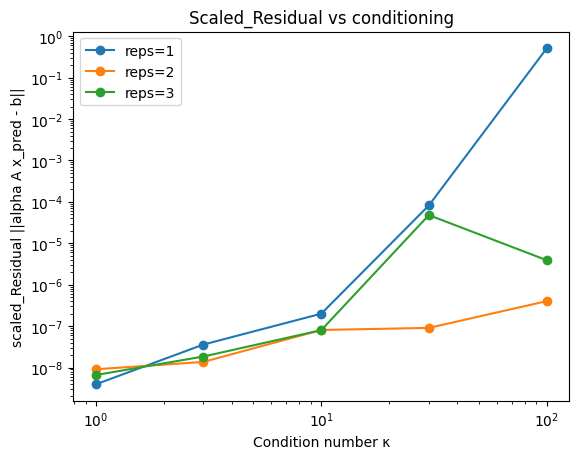

In [82]:

for reps, sub in df.groupby("reps"):
        sub = sub.sort_values("kappa")
        plt.plot(sub["kappa"], sub["scaled_residual"], marker="o", label=f"reps={reps}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Condition number κ")
plt.ylabel("scaled_Residual ||alpha A x_pred - b||")
plt.title("Scaled_Residual vs conditioning")
plt.legend()
plt.show()

## VQLS with Noise 

In [96]:
#Imports and Noise Model
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

def make_noise_model(p1=0.001, p2=0.02, p_ro=0.0):
    nm = NoiseModel()

    # 1-qubit depolarizing noise on common gates
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ["ry", "rz", "x", "h"])

    # 2-qubit depolarizing noise on CX
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ["cx"])

    # Optional readout error
    if p_ro and p_ro > 0:
        ro = ReadoutError([[1 - p_ro, p_ro],
                           [p_ro, 1 - p_ro]])
        nm.add_all_qubit_readout_error(ro)

    return nm

In [100]:
#Estimator definition based on Noise Model
def make_estimator_v2(noise=False, p1=0.001, p2=0.02, p_ro=0.0, shots=2000, seed_sim=1):
    """
    Returns an Aer EstimatorV2 (your Estimator alias) configured either ideal or noisy.
    Tries multiple constructor signatures for compatibility across Aer versions.
    """
    if not noise:
        return EstimatorV2()  # your: from qiskit_aer.primitives import EstimatorV2 as Estimator

    nm = make_noise_model(p1=p1, p2=p2, p_ro=p_ro)

    backend = AerSimulator(
        noise_model=nm,
        shots=shots,
        seed_simulator=seed_sim
    )

    # Try the most common signatures first
    try:
        return EstimatorV2(backend=backend)
    except TypeError:
        pass

    try:
        return EstimatorV2(backend=backend, options={"shots": shots})
    except TypeError:
        pass

    # Fallback: options-based backend injection (some versions use backend_options)
    try:
        return EstimatorV2(options={"backend_options": {"noise_model": nm, "shots": shots, "seed_simulator": seed_sim}})
    except TypeError as e:
        raise TypeError(
            "Could not configure EstimatorV2 with noise in this Aer version. "
            "Try printing Estimator.__init__.__doc__ or share the TypeError message."
        ) from e

In [108]:
#Final function (including Noise)
def run_vqls_CaseI_noise(kappa, reps, optimizer="COBYLA", maxiter=300, seed=0, noise=False, p1=0.001, p2=0.02, p_ro=0.0, shots=2000, cost_avg=1):
    np.random.seed(seed)

    # Build A and b
    A = CaseI_A_matrix(kappa)
    #A = familyA_A(kappa)
    U = make_U("H0_CNOT")
    A_mat = rotate_A(A, U)
    b = b_bell_4()
    #b = make_b_uniform()
    b = normalize(b)
    x_true = classical_solution(A_mat, b)

    # Operators
    A_op = SparsePauliOp.from_operator(A_mat)
    H = cost_hamiltonian(A_op, b)

    # Ansatz
    ansatz = make_ansatz(n_qubits=2, reps=reps)

    # Estimator
    estimator = make_estimator_v2(
        noise=noise, p1=p1, p2=p2, p_ro=p_ro, shots=shots, seed_sim=seed
    )

    def costfunc(params):
        vals = []
        for _ in range(cost_avg):  
            job = estimator.run([(ansatz, H, params)])
            vals.append(float(job.result()[0].data.evs))
        return float(np.mean(vals))
        

    init = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

    res = minimize(costfunc, init, method=optimizer, options={"maxiter": maxiter, "tol": 1e-4})

    # Evaluate final state
    x_pred = state_from_params(ansatz, res.x)
    x_pred = normalize(x_pred)

    # Optional: align global sign for nicer comparisons
    if np.real(np.vdot(x_true, x_pred)) < 0:
        x_pred = -x_pred
    
    raw_residual = np.linalg.norm(A_mat @ x_pred - b)
    
    Ax = A_mat @ x_pred
    alpha = np.vdot(Ax, b) / np.vdot(Ax, Ax)   
    scaled_residual = np.linalg.norm(alpha*Ax - b)

    return {
        "kappa": kappa,
        "reps": reps,
        "optimizer": optimizer,
        "final_cost": res.fun,
        "iters": res.nfev,          # note: this is function evals, not iterations
        "fidelity": fidelity(x_true, x_pred),
        "A_terms": pauli_term_count(A_op),
        "H_terms": pauli_term_count(H),
        "x_true": x_true,
        "x_pred": x_pred,
        "raw_residual": raw_residual,
        "scaled_residual": scaled_residual
    }

In [105]:
out = run_vqls_CaseI_noise(100, 2, optimizer="COBYLA", maxiter=300, seed=0, noise=True, p1=0.001, p2=0.02, p_ro=0.0, shots=2000, cost_avg=3)
print(out)

{'kappa': 100, 'reps': 2, 'optimizer': 'COBYLA', 'final_cost': np.float64(0.02440524265807999), 'iters': np.int64(300), 'fidelity': np.float64(0.9999996177829261), 'A_terms': 4, 'H_terms': 160, 'x_true': array([ 7.14070746e-01+0.j, -6.99930732e-01+0.j, -3.16328295e-19+0.j,
        1.41400148e-02+0.j]), 'x_pred': array([ 7.13863701e-01-0.j, -7.00152475e-01-0.j,  7.05499800e-05-0.j,
        1.36059718e-02-0.j]), 'raw_residual': np.float64(0.9805322245344409), 'scaled_residual': np.float64(0.016409854258199054)}


Vary shots

Vary p2values

vary cost_avg

vary max itr

change optimizer

In [109]:
#For different functions
p2s = [0.0,0.01,0.02]

results = []
for p2 in p2s:
    out = run_vqls_CaseI_noise(kappa=100,reps=2,noise = True, maxiter=600, seed=1,p2=p2,shots=2000,cost_avg=3)
    results.append(out)
    print(out)

{'kappa': 100, 'reps': 2, 'optimizer': 'COBYLA', 'final_cost': np.float64(0.0021630464737964674), 'iters': np.int64(600), 'fidelity': np.float64(0.9999998108921332), 'A_terms': 4, 'H_terms': 160, 'x_true': array([ 7.14070746e-01+0.j, -6.99930732e-01+0.j, -3.16328295e-19+0.j,
        1.41400148e-02+0.j]), 'x_pred': array([ 7.13796375e-01+0.j, -7.00212691e-01+0.j,  1.50619646e-04+0.j,
        1.40321226e-02+0.j]), 'raw_residual': np.float64(0.9802760149508166), 'scaled_residual': np.float64(0.01715861138786313)}
{'kappa': 100, 'reps': 2, 'optimizer': 'COBYLA', 'final_cost': np.float64(0.013314798767151602), 'iters': np.int64(600), 'fidelity': np.float64(0.9999999154007646), 'A_terms': 4, 'H_terms': 160, 'x_true': array([ 7.14070746e-01+0.j, -6.99930732e-01+0.j, -3.16328295e-19+0.j,
        1.41400148e-02+0.j]), 'x_pred': array([ 7.13899188e-01+0.j, -7.00104931e-01+0.j,  1.52926706e-04+0.j,
        1.41778950e-02+0.j]), 'raw_residual': np.float64(0.980098487055898), 'scaled_residual': np.

Plotting comparison plots

We are doing four comparison plots

1. different p2 values
2. different shots
3. Different Cost_avg
4. Different depths under noise

In [113]:
import pandas as pd

def run_sweep(configs, seeds=(0,1,2)):
    """
    configs: list of dicts, each dict contains parameters to pass into run_vqls_CaseI
    returns: pandas DataFrame with one row per (config, seed)
    """
    rows = []
    for cfg_id, cfg in enumerate(configs):
        for s in seeds:
            out = run_vqls_CaseI_noise(seed=s, **cfg)  
            out2 = dict(out)
            out2["cfg_id"] = cfg_id
            for k, v in cfg.items():
                # store the sweep parameters in the table
                if k not in out2:
                    out2[k] = v
            rows.append(out2)
    return pd.DataFrame(rows)

def summarize(df, group_cols):
    """
    Returns mean/std summaries for key metrics.
    """
    metrics = ["final_cost", "scaled_residual", "fidelity", "iters"]
    agg = {}
    for m in metrics:
        if m in df.columns:
            agg[m+"_mean"] = (m, "mean")
            agg[m+"_std"]  = (m, "std")
    return df.groupby(group_cols).agg(**agg).reset_index()

In [114]:
def configs_p2_sweep(kappa=100, reps=2, p1=0.001, p2_list=(0,0.005,0.01,0.02,0.03),
                     shots=2000, cost_avg=3, maxiter=600, optimizer="COBYLA"):
    return [
        dict(kappa=kappa, reps=reps, optimizer=optimizer, maxiter=maxiter,
             noise=True, p1=p1, p2=p2, p_ro=0.0, shots=shots, cost_avg=cost_avg)
        for p2 in p2_list
    ]

def configs_shots_sweep(kappa=100, reps=2, p1=0.001, p2=0.02, shots_list=(200,500,1000,2000),
                        cost_avg=3, maxiter=600, optimizer="COBYLA"):
    return [
        dict(kappa=kappa, reps=reps, optimizer=optimizer, maxiter=maxiter,
             noise=True, p1=p1, p2=p2, p_ro=0.0, shots=sh, cost_avg=cost_avg)
        for sh in shots_list
    ]

def configs_costavg_sweep(kappa=100, reps=2, p1=0.001, p2=0.02,
                          shots=2000, cost_avg_list=(1,3,5), maxiter=600, optimizer="COBYLA"):
    return [
        dict(kappa=kappa, reps=reps, optimizer=optimizer, maxiter=maxiter,
             noise=True, p1=p1, p2=p2, p_ro=0.0, shots=shots, cost_avg=ca)
        for ca in cost_avg_list
    ]

def configs_reps_sweep(kappa=100, reps_list=(1,2,3), p1=0.001, p2=0.02,
                       shots=2000, cost_avg=3, maxiter=600, optimizer="COBYLA"):
    return [
        dict(kappa=kappa, reps=r, optimizer=optimizer, maxiter=maxiter,
             noise=True, p1=p1, p2=p2, p_ro=0.0, shots=shots, cost_avg=cost_avg)
        for r in reps_list
    ]

In [115]:
#Plotting code 
def plot_errorbar(summary_df, xcol, ymean, ystd, xlabel, ylabel, title, xlog=False, ylog=False):
    plt.figure()
    x = summary_df[xcol].values
    y = summary_df[ymean].values
    e = summary_df[ystd].values if ystd in summary_df.columns else None
    plt.errorbar(x, y, yerr=e, marker="o", capsize=3)
    if xlog:
        plt.xscale("log")
    if ylog:
        plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

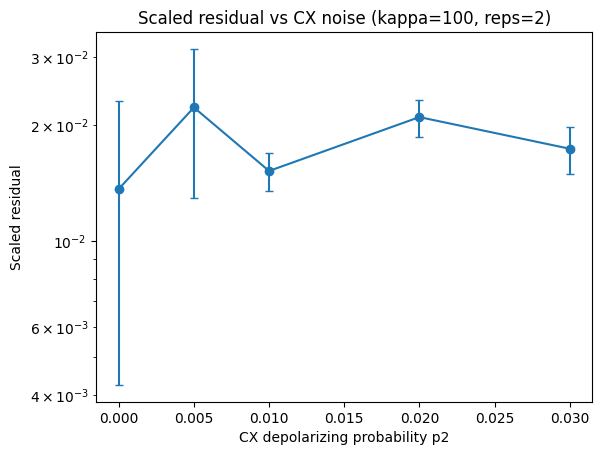

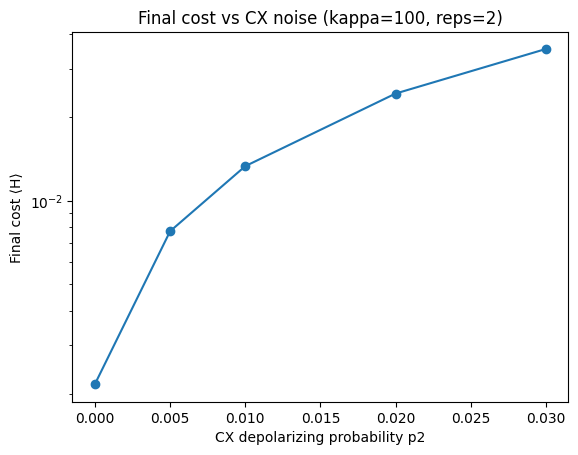

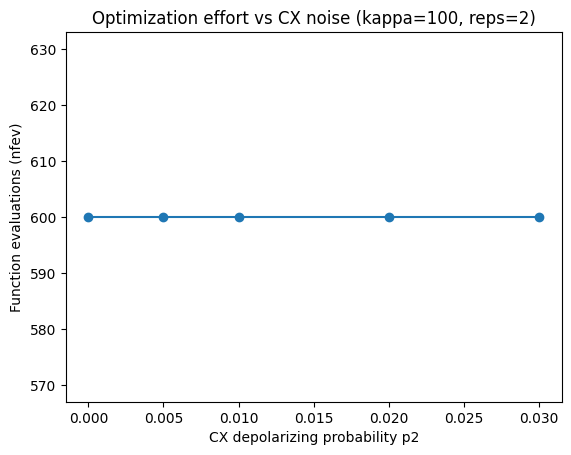

In [116]:
#Different P2 values
# 1) p2 sweep
configs = configs_p2_sweep()
df = run_sweep(configs, seeds=(0,1,2))
summ = summarize(df, group_cols=["p2"])

plot_errorbar(
    summ, xcol="p2",
    ymean="scaled_residual_mean", ystd="scaled_residual_std",
    xlabel="CX depolarizing probability p2",
    ylabel="Scaled residual",
    title="Scaled residual vs CX noise (kappa=100, reps=2)",
    xlog=False, ylog=True
)

plot_errorbar(
    summ, xcol="p2",
    ymean="final_cost_mean", ystd="final_cost_std",
    xlabel="CX depolarizing probability p2",
    ylabel="Final cost ⟨H⟩",
    title="Final cost vs CX noise (kappa=100, reps=2)",
    xlog=False, ylog=True
)

plot_errorbar(
    summ, xcol="p2",
    ymean="iters_mean", ystd="iters_std",
    xlabel="CX depolarizing probability p2",
    ylabel="Function evaluations (nfev)",
    title="Optimization effort vs CX noise (kappa=100, reps=2)",
    xlog=False, ylog=False
)

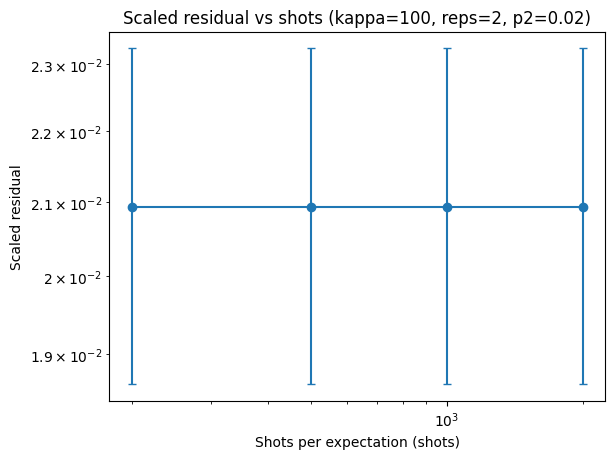

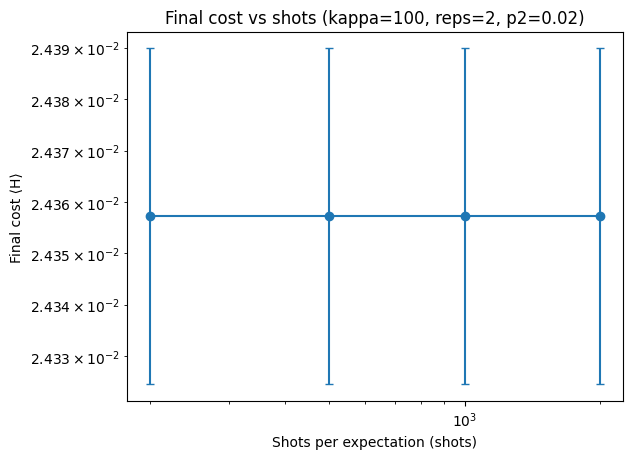

In [117]:
#Different number of shots
# 2) shots sweep
configs = configs_shots_sweep()
df = run_sweep(configs, seeds=(0,1,2))
summ = summarize(df, group_cols=["shots"])

plot_errorbar(
    summ, xcol="shots",
    ymean="scaled_residual_mean", ystd="scaled_residual_std",
    xlabel="Shots per expectation (shots)",
    ylabel="Scaled residual",
    title="Scaled residual vs shots (kappa=100, reps=2, p2=0.02)",
    xlog=True, ylog=True
)

plot_errorbar(
    summ, xcol="shots",
    ymean="final_cost_mean", ystd="final_cost_std",
    xlabel="Shots per expectation (shots)",
    ylabel="Final cost ⟨H⟩",
    title="Final cost vs shots (kappa=100, reps=2, p2=0.02)",
    xlog=True, ylog=True
)

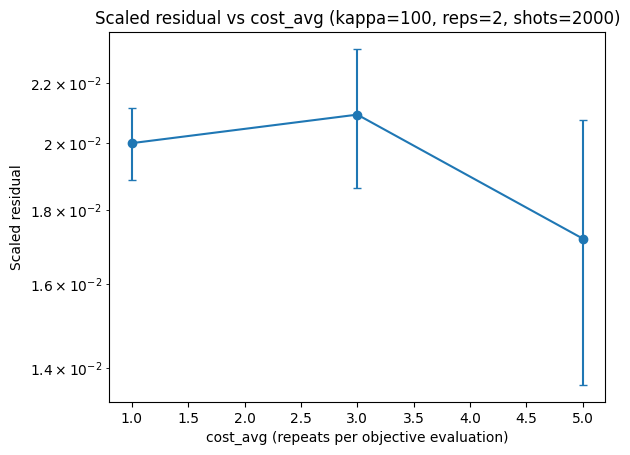

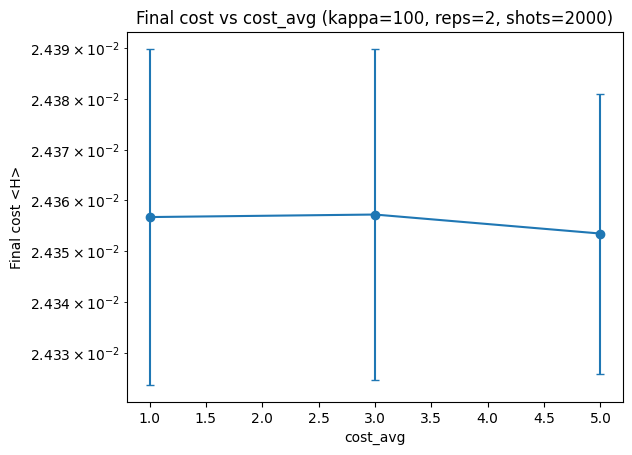

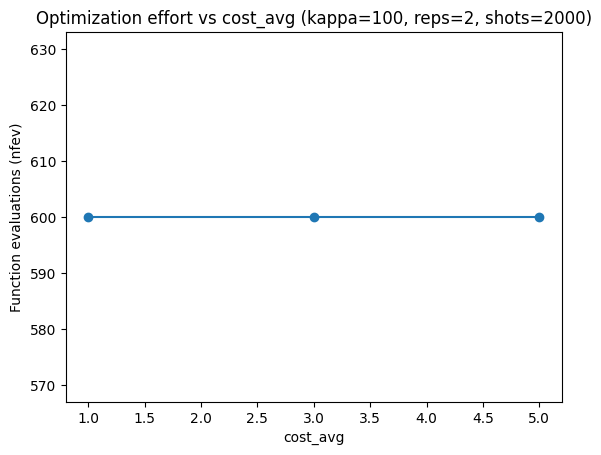

In [119]:
#Different cost_avg values
configs = configs_costavg_sweep()
df = run_sweep(configs, seeds=(0,1,2))
summ = summarize(df, group_cols=["cost_avg"])

# Plots
plot_errorbar(
    summ, xcol="cost_avg",
    ymean="scaled_residual_mean", ystd="scaled_residual_std",
    xlabel="cost_avg (repeats per objective evaluation)",
    ylabel="Scaled residual",
    title="Scaled residual vs cost_avg (kappa=100, reps=2, shots=2000)",
    xlog=False, ylog=True
)

plot_errorbar(
    summ, xcol="cost_avg",
    ymean="final_cost_mean", ystd="final_cost_std",
    xlabel="cost_avg",
    ylabel="Final cost <H>",
    title="Final cost vs cost_avg (kappa=100, reps=2, shots=2000)",
    xlog=False, ylog=True
)

plot_errorbar(
    summ, xcol="cost_avg",
    ymean="iters_mean", ystd="iters_std",
    xlabel="cost_avg",
    ylabel="Function evaluations (nfev)",
    title="Optimization effort vs cost_avg (kappa=100, reps=2, shots=2000)",
    xlog=False, ylog=False
)

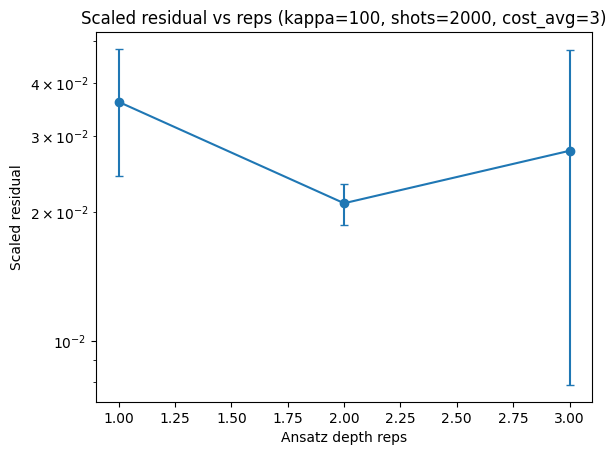

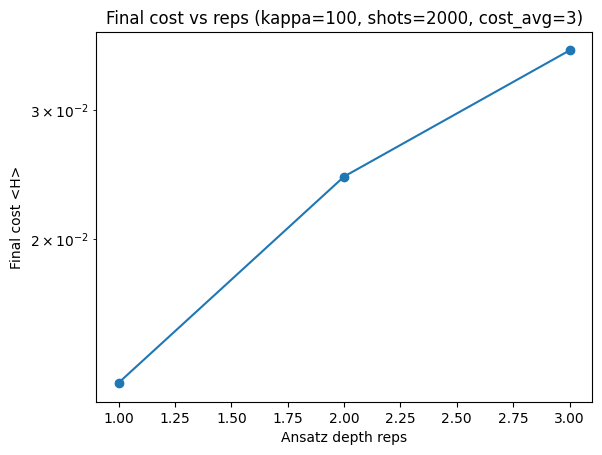

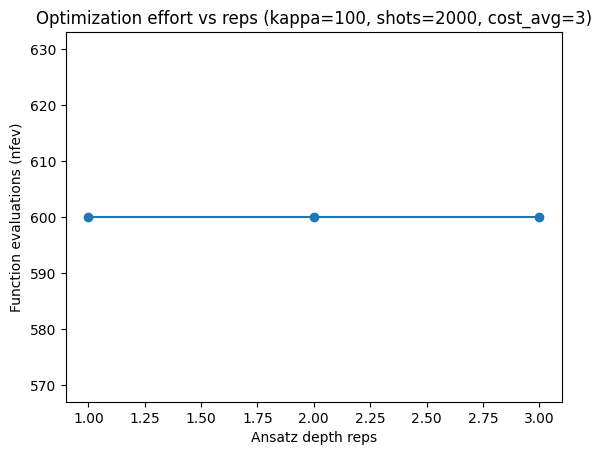

In [120]:
#Different reps under Noise
configs = configs_reps_sweep()
df = run_sweep(configs, seeds=(0,1,2))
summ = summarize(df, group_cols=["reps"])

plot_errorbar(
    summ, xcol="reps",
    ymean="scaled_residual_mean", ystd="scaled_residual_std",
    xlabel="Ansatz depth reps",
    ylabel="Scaled residual",
    title="Scaled residual vs reps (kappa=100, shots=2000, cost_avg=3)",
    xlog=False, ylog=True
)

plot_errorbar(
    summ, xcol="reps",
    ymean="final_cost_mean", ystd="final_cost_std",
    xlabel="Ansatz depth reps",
    ylabel="Final cost <H>",
    title="Final cost vs reps (kappa=100, shots=2000, cost_avg=3)",
    xlog=False, ylog=True
)

plot_errorbar(
    summ, xcol="reps",
    ymean="iters_mean", ystd="iters_std",
    xlabel="Ansatz depth reps",
    ylabel="Function evaluations (nfev)",
    title="Optimization effort vs reps (kappa=100, shots=2000, cost_avg=3)",
    xlog=False, ylog=False
)

### Different Optimizers (COBYLA vs SPSA)

In [139]:
def wrap_2pi(x):
    return np.mod(x, 2*np.pi)

def spsa_optimize(costfunc, x0, max_steps=200, a=0.2, c=0.1, A=50,
                  alpha=0.602, gamma=0.101, seed=0, clip=(0.0, 2*np.pi),
                  extra_cost_eval_per_step=True):
    """
    SPSA optimizer for noisy cost functions.

    Returns:
      x_best, f_best, nfev, history
    """
    rng = np.random.default_rng(seed)
    x = wrap_2pi(np.array(x0, dtype=float))

    #lo, hi = clip if clip is not None else (-np.inf, np.inf)

    nfev = 0
    history = []

    # Evaluate initial
    f = costfunc(x); nfev += 1
    x_best = x.copy()
    f_best = f

    for k in range(1, max_steps + 1):
        ak = a / ((k + A) ** alpha)
        ck = c / (k ** gamma)

        delta = rng.choice([-1.0, 1.0], size=x.shape)

        x_plus = wrap_2pi(x + ck * delta)
        x_minus = wrap_2pi(x - ck * delta)

        f_plus = costfunc(x_plus);  nfev += 1
        f_minus = costfunc(x_minus); nfev += 1

        # SPSA gradient estimate
        ghat = (f_plus - f_minus) / (2.0 * ck) * (1.0 / delta)

        # Update
        x = wrap_2pi(x - ak * ghat)

        # Optionally evaluate current x for logging/early best
        if extra_cost_eval_per_step:
            f = costfunc(x); nfev += 1
        else:
            # cheap proxy (not recommended)
            f = 0.5 * (f_plus + f_minus)

        if f < f_best:
            f_best = f
            x_best = x.copy()

        history.append({"step": k, "cost": f, "ak": ak, "ck": ck})

    return x_best, f_best, nfev, history

In [143]:
import numpy as np

def wrap_2pi(x):
    return np.mod(x, 2*np.pi)

def spsa_optimize_calibrated(costfunc, x0, max_steps=200, A=50,
                             alpha=0.602, gamma=0.101, seed=0,
                             target_step=0.05,   # radians: desired typical first-step parameter change
                             c0=0.05,            # initial perturbation scale (works well for RY angles)
                             extra_cost_eval_per_step=True):
    """
    SPSA with automatic step-size calibration.
    - c0 sets the perturbation scale (try 0.02–0.1 for angle params)
    - target_step sets how big the first parameter update should be
    """
    rng = np.random.default_rng(seed)
    x = wrap_2pi(np.array(x0, dtype=float))
    nfev = 0
    history = []

    # --- calibration: estimate gradient scale at x0 ---
    delta0 = rng.choice([-1.0, 1.0], size=x.shape)
    x_plus0 = wrap_2pi(x + c0 * delta0)
    x_minus0 = wrap_2pi(x - c0 * delta0)

    f_plus0 = costfunc(x_plus0);  nfev += 1
    f_minus0 = costfunc(x_minus0); nfev += 1

    ghat0 = (f_plus0 - f_minus0) / (2.0 * c0) * (1.0 / delta0)
    gscale = np.median(np.abs(ghat0)) + 1e-12  # robust scale

    # choose a0 so typical |a0 * g| ≈ target_step
    a0 = target_step / gscale

    # initial evaluation
    f = costfunc(x); nfev += 1
    x_best, f_best = x.copy(), f

    for k in range(1, max_steps + 1):
        ak = a0 / ((k + A) ** alpha)
        ck = c0 / (k ** gamma)

        delta = rng.choice([-1.0, 1.0], size=x.shape)
        x_plus = wrap_2pi(x + ck * delta)
        x_minus = wrap_2pi(x - ck * delta)

        f_plus = costfunc(x_plus);  nfev += 1
        f_minus = costfunc(x_minus); nfev += 1

        ghat = (f_plus - f_minus) / (2.0 * ck) * (1.0 / delta)
        x = wrap_2pi(x - ak * ghat)

        if extra_cost_eval_per_step:
            f = costfunc(x); nfev += 1
        else:
            f = 0.5 * (f_plus + f_minus)

        if f < f_best:
            f_best, x_best = f, x.copy()

        history.append({"step": k, "cost": f, "ak": ak, "ck": ck})

    return x_best, f_best, nfev, history

In [144]:

def run_vqls_CaseI_noise(
    kappa, reps,
    optimizer="COBYLA",
    maxiter=300, seed=0,
    noise=False, p1=0.001, p2=0.02, p_ro=0.0,
    shots=2000, cost_avg=1,
    # SPSA params (only used when optimizer="SPSA")
    spsa_steps=200, spsa_a=0.002, spsa_c=0.01, spsa_A=50
):
    np.random.seed(seed)

    # Build A and b
    A = CaseI_A_matrix(kappa)
    U = make_U("H0_CNOT")
    A_mat = rotate_A(A, U)
    b = b_bell_4()
    b = normalize(b)
    x_true = classical_solution(A_mat, b)

    # Operators
    A_op = SparsePauliOp.from_operator(A_mat)
    H = cost_hamiltonian(A_op, b)

    # Ansatz
    ansatz = make_ansatz(n_qubits=2, reps=reps)

    # Estimator
    estimator = make_estimator_v2(
        noise=noise, p1=p1, p2=p2, p_ro=p_ro, shots=shots, seed_sim=seed
    )

    def costfunc(params):
        vals = []
        for _ in range(cost_avg):
            job = estimator.run([(ansatz, H, params)])
            vals.append(float(job.result()[0].data.evs))
        return float(np.mean(vals))

    init = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

    # ---------- optimizer selection ----------
    history = None

    if str(optimizer).upper() == "SPSA":
        x_opt, f_opt, nfev, history = spsa_optimize_calibrated(
            costfunc, init,
            max_steps=spsa_steps,
            A=spsa_A,
            seed=seed,
            target_step=0.05,
            c0=0.05,
            extra_cost_eval_per_step=True
        )
        final_cost = f_opt
        iters = nfev

    else:
        res = minimize(costfunc, init, method=optimizer,
                       options={"maxiter": maxiter, "tol": 1e-4})
        x_opt = res.x
        final_cost = float(res.fun)
        iters = int(res.nfev)

    # Evaluate final state (statevector is ideal; keep consistent)
    x_pred = state_from_params(ansatz, x_opt)
    x_pred = normalize(x_pred)

    # Optional: align global sign for nicer comparisons
    if np.real(np.vdot(x_true, x_pred)) < 0:
        x_pred = -x_pred

    raw_residual = np.linalg.norm(A_mat @ x_pred - b)

    Ax = A_mat @ x_pred
    alpha = np.vdot(Ax, b) / np.vdot(Ax, Ax)
    scaled_residual = np.linalg.norm(alpha * Ax - b)

    out = {
        "kappa": kappa,
        "reps": reps,
        "optimizer": optimizer,
        "final_cost": final_cost,
        "iters": iters,
        "fidelity": fidelity(x_true, x_pred),
        "A_terms": pauli_term_count(A_op),
        "H_terms": pauli_term_count(H),
        "x_true": x_true,
        "x_pred": x_pred,
        "raw_residual": raw_residual,
        "scaled_residual": scaled_residual
    }

    # Optional: include SPSA trace
    if history is not None:
        out["history"] = history

    return out

In [145]:
cfg = dict(kappa=100, reps=2, noise=False, p1=0.001, p2=0.02, shots=2000, cost_avg=3)

out_cobyla = run_vqls_CaseI_noise(**cfg, optimizer="COBYLA", maxiter=600, seed=0)
out_spsa   = run_vqls_CaseI_noise(**cfg, optimizer="SPSA", spsa_steps=200, seed=0)

print(out_cobyla["final_cost"], out_cobyla["scaled_residual"], out_cobyla["iters"])
print(out_spsa["final_cost"], out_spsa["scaled_residual"], out_spsa["iters"])

1.2857167756667731e-09 0.001797769545348025 94
0.30699071725023025 0.8422362117677495 603


In [128]:
cfg = dict(kappa=100, reps=2, noise=True, p1=0.001, p2=0.02, shots=2000, cost_avg=3)

tests = [
    ("SPSA-1", 0.05, 0.10, 50),
    ("SPSA-2", 0.02, 0.08, 50),
    ("SPSA-3", 0.08, 0.06, 50),
]

for name, a, c, A in tests:
    out = run_vqls_CaseI_noise(**cfg, optimizer="SPSA",
                              spsa_steps=200, spsa_a=a, spsa_c=c, spsa_A=A,
                              seed=0)
    print(name, "cost", out["final_cost"], "scaled_res", out["scaled_residual"], "nfev", out["iters"])

SPSA-1 cost 0.3151307464628754 scaled_res 0.8386404552611949 nfev 601
SPSA-2 cost 0.435269971262791 scaled_res 0.8931118040370476 nfev 601
SPSA-3 cost 0.2268120229444001 scaled_res 0.777565267960005 nfev 601
